In [1]:
import os

from dotenv import load_dotenv

from dynamic_pricing.core.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools


load_dotenv()
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("future.no_silent_downcasting", True)

### Establish database connection

In [ ]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn, os.getenv("PARTNER1"))
print(df.info)

In [3]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

exclusion_categories = [
    "Desserts",
    "Soft Drinks",
    "Starters and Sharers",
    "Handmade Single Grills",
]

for category in exclusion_categories:
    df = df[~df["item_operational_name"].str.contains(category)]


Index(['order_id', 'platform_order_id', 'platform_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'platform_item_id',
       'item_name', 'item_operational_name', 'item_fractional_cost',
       'item_quantity', 'item_fractional_price', 'modifier_id',
       'platform_modifier_id', 'modifier_name', 'modifier_operational_name',
       'modifier_quantity', 'modifier_fractional_price'],
      dtype='object')


Filter to keep only the items we are analyzing

In [4]:
pre_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-06-26")
    & (df["order_placed_timestamp"] < "2023-7-17")
]


post_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-7-17")
    & (df["order_placed_timestamp"] < "2023-8-07")
]


seasonal_dp_df = df[
    (df["order_placed_timestamp"] >= "2023-8-07")
    & (df["order_placed_timestamp"] < "2024-3-26")
]

seasonal_dp_df = seasonal_dp_df[~seasonal_dp_df["item_operational_name"].str.contains("Wrap")]

seasonal_dp_df.info()

interval = 30 #signifies 30 minutes

<class 'pandas.core.frame.DataFrame'>
Index: 1081 entries, 550 to 5399
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           1081 non-null   int64         
 1   platform_order_id                  1081 non-null   object        
 2   platform_order_number              1081 non-null   int64         
 3   order_status                       1081 non-null   object        
 4   order_placed_timestamp             1081 non-null   datetime64[ns]
 5   order_updated_timestamp            1081 non-null   datetime64[ns]
 6   order_prepare_for_timestamp        1081 non-null   datetime64[ns]
 7   order_start_prepping_at_timestamp  1081 non-null   datetime64[ns]
 8   customer_id                        1081 non-null   object        
 9   first_name                         1081 non-null   object        
 10  contact_number                     1081

In [5]:
from dynamic_pricing.analysis.metrics import split_weekdays_and_weekends

seasonal_dp_df_weekdays, seasonal_dp_df_weekends = split_weekdays_and_weekends(
    seasonal_dp_df, "order_placed_timestamp"
)

### Data analysis of core demand and supply metrics
Since the data for this analysis is from extend post-dp segment, there are only two plots for each sell:  post-dp weekday, post-dp weekend

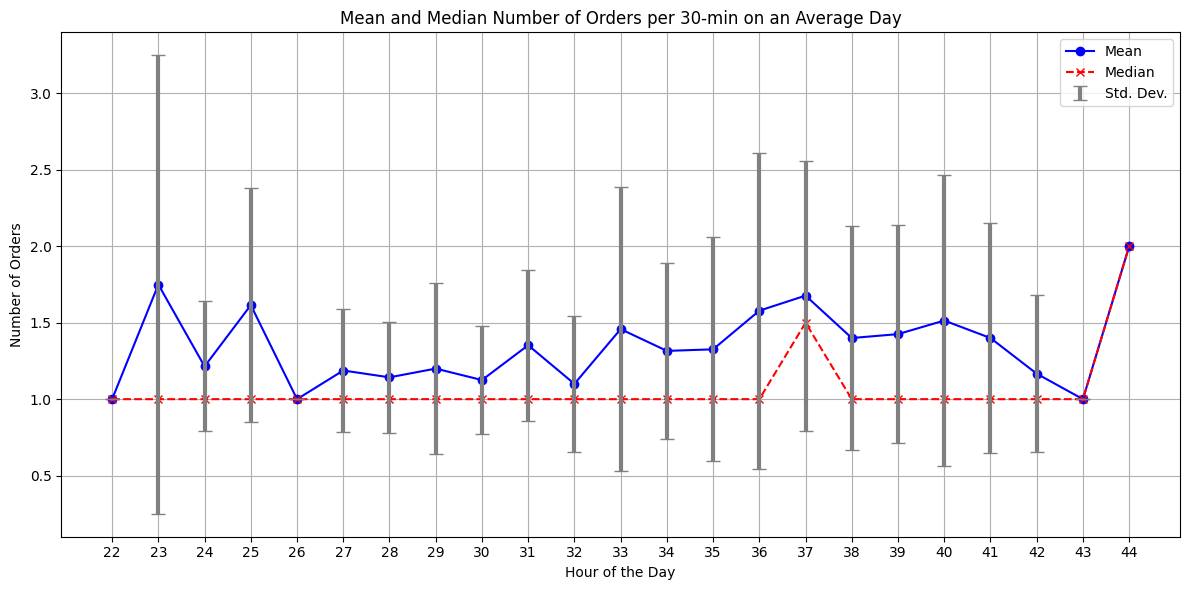

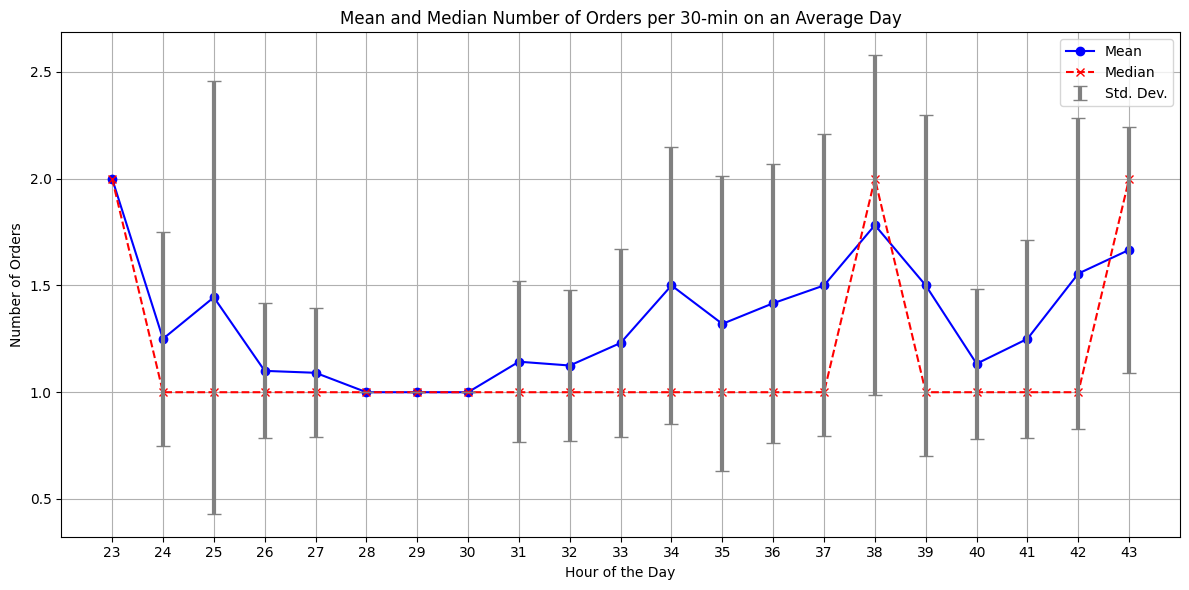

In [6]:
from dynamic_pricing.analysis.metrics import (
    calculate_average_orders_per_interval,
)

calculate_average_orders_per_interval(seasonal_dp_df_weekdays, interval=interval,plot =True)
calculate_average_orders_per_interval(seasonal_dp_df_weekends, interval=interval,plot=True)

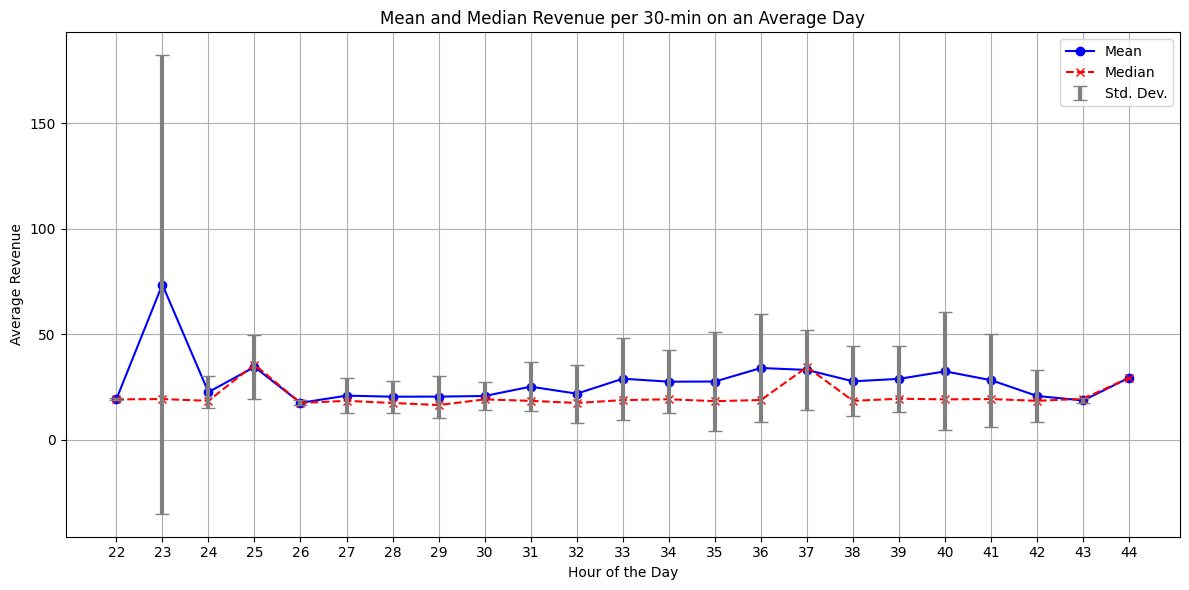

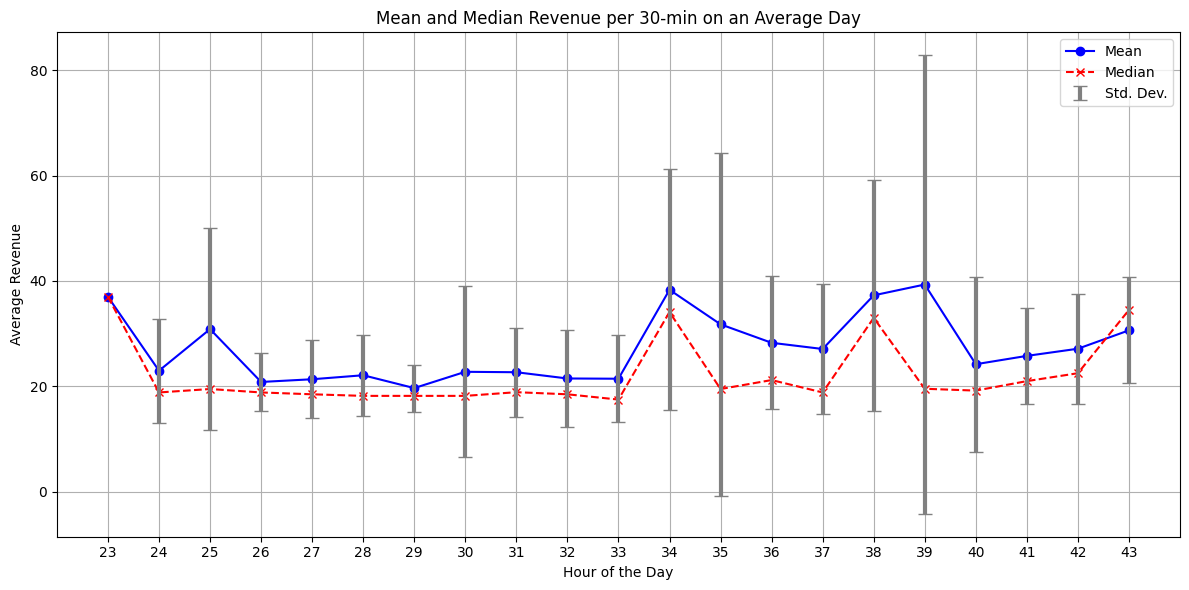

In [7]:
from dynamic_pricing.analysis.metrics import (
    calculate_average_revenue_per_interval,
)

calculate_average_revenue_per_interval(
    seasonal_dp_df_weekdays, interval, plot=True
)
calculate_average_revenue_per_interval(
    seasonal_dp_df_weekends, interval, plot=True
)

### Additional analytics

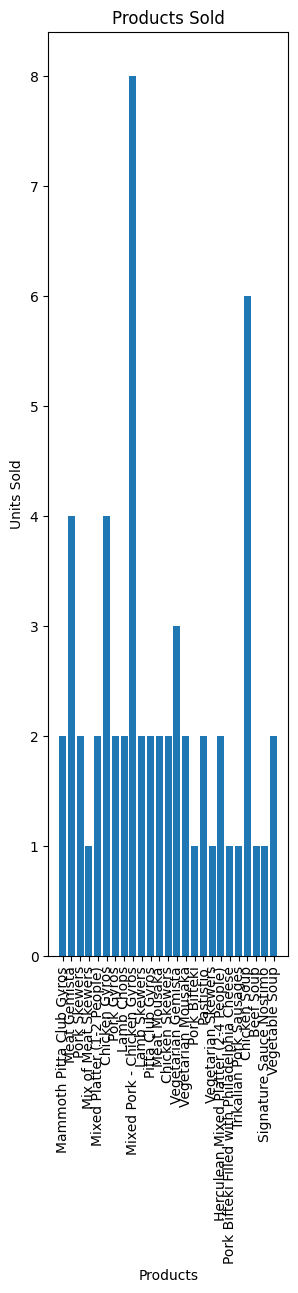

In [8]:
from dynamic_pricing.analysis.metrics import plot_items_sold

plot_items_sold(seasonal_dp_df)

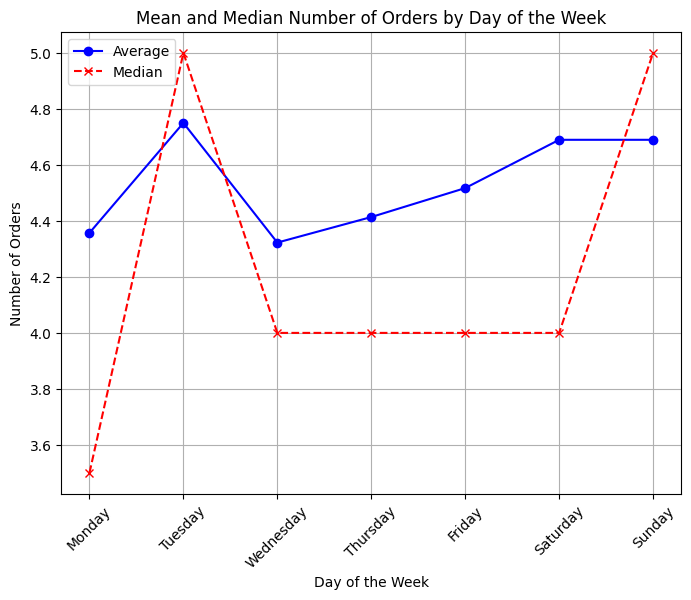

In [9]:
from dynamic_pricing.analysis.metrics import calculate_average_orders_by_day_of_week
calculate_average_orders_by_day_of_week(seasonal_dp_df,plot=True)

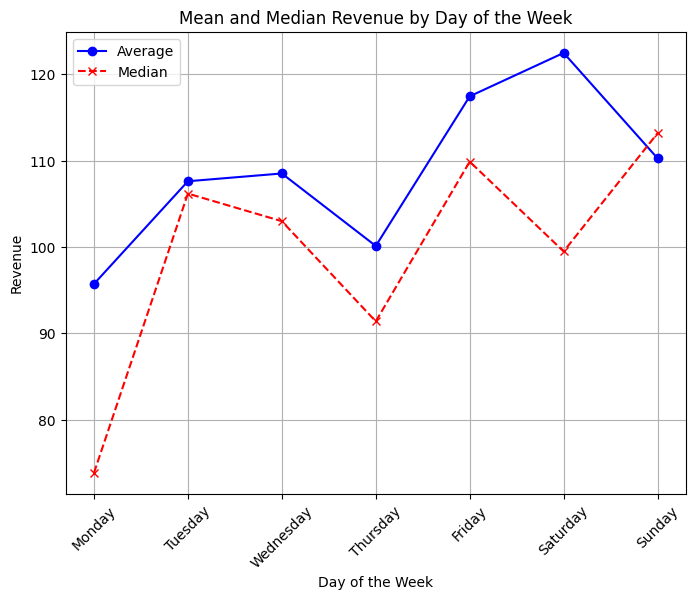

In [10]:
from dynamic_pricing.analysis.metrics import calculate_average_revenue_by_day_of_week

calculate_average_revenue_by_day_of_week(seasonal_dp_df, plot=True)

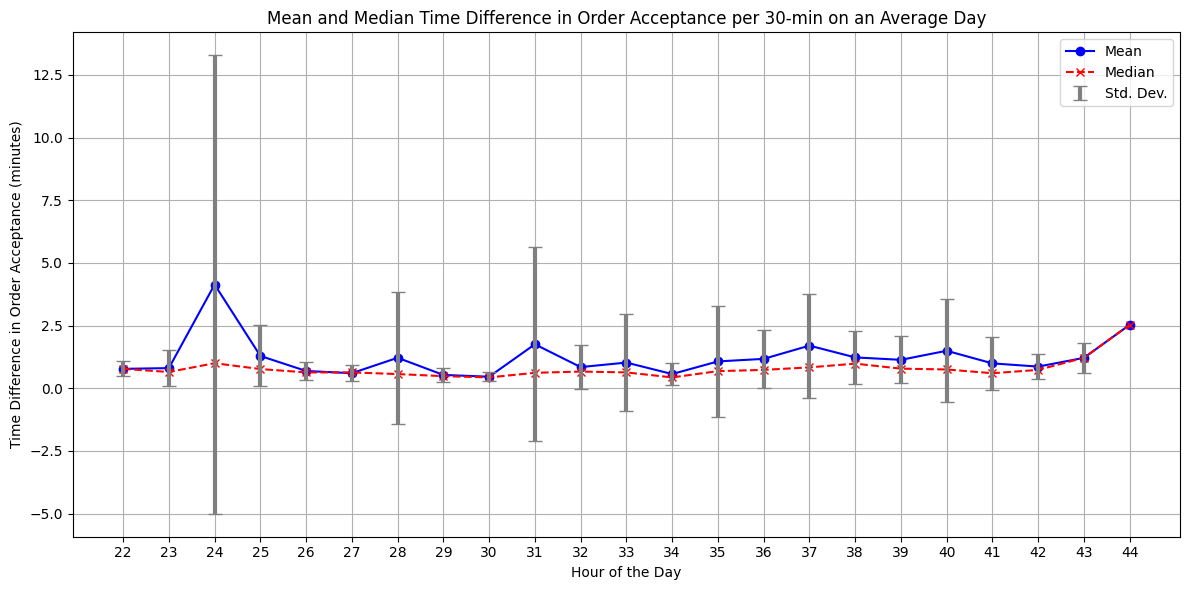

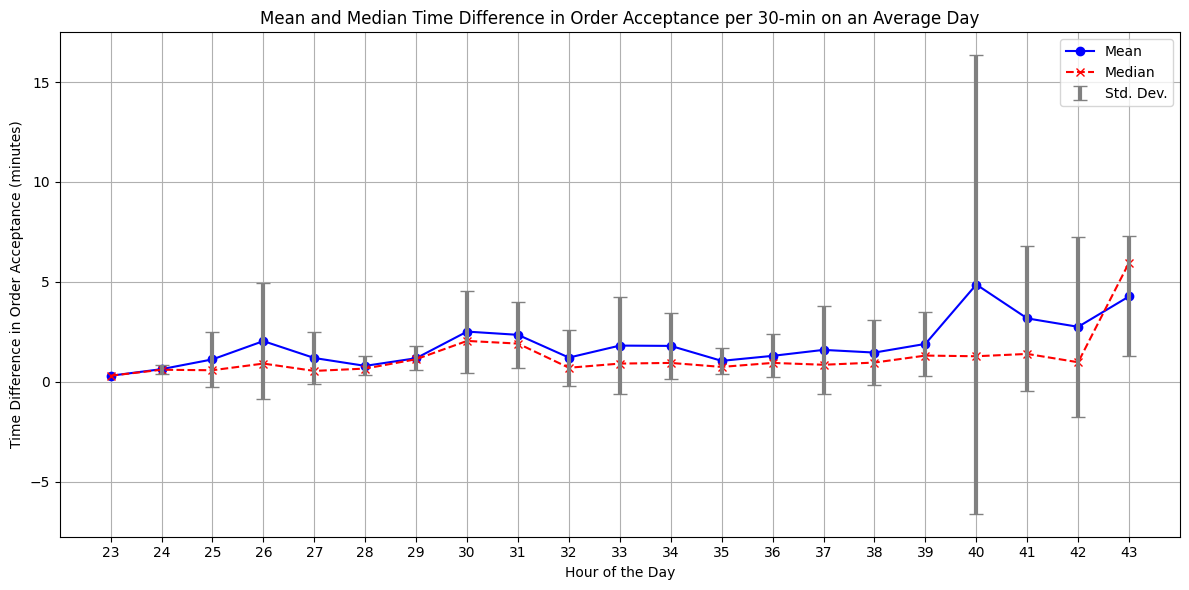

In [11]:
from dynamic_pricing.analysis.metrics import (
    calculate_time_difference_in_order_acceptance_per_interval,
)

calculate_time_difference_in_order_acceptance_per_interval(seasonal_dp_df_weekdays, interval,plot=True)
calculate_time_difference_in_order_acceptance_per_interval(
    seasonal_dp_df_weekends, interval, plot=True
)

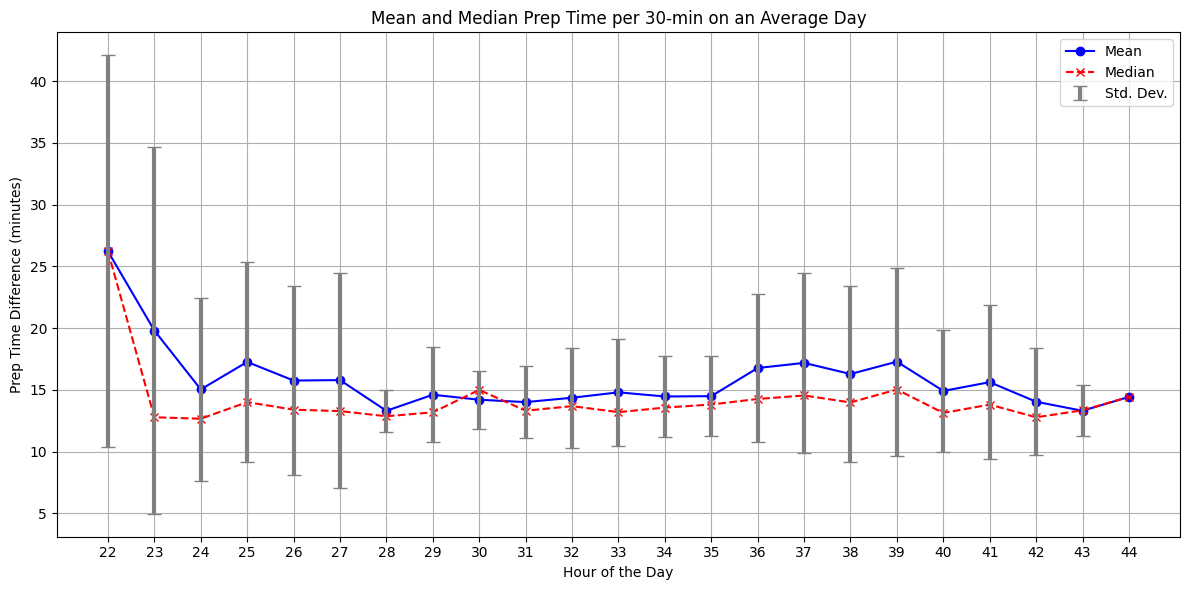

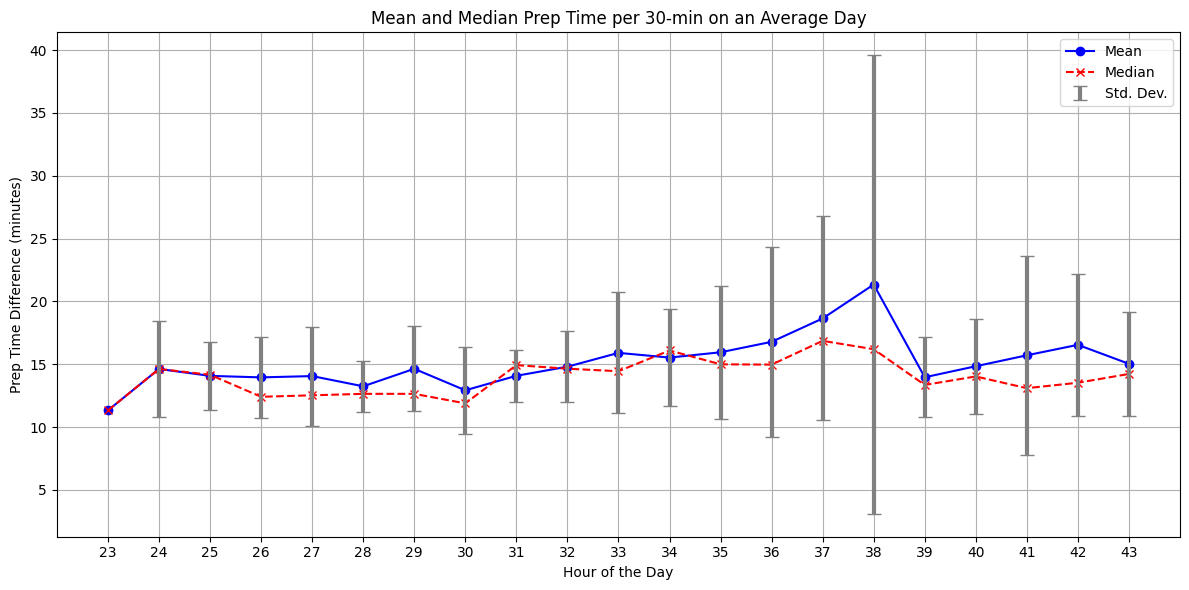

In [12]:
from dynamic_pricing.analysis.metrics import calculate_prep_time_per_interval

calculate_prep_time_per_interval(seasonal_dp_df_weekdays, interval, plot=True)
calculate_prep_time_per_interval(seasonal_dp_df_weekends, interval,plot=True)

In [13]:
from dynamic_pricing.analysis.metrics import calculate_revenue_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
seasonal_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    seasonal_dp_df_weekdays, time_intervals=time_intervals
)
seasonal_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    seasonal_dp_df_weekends, time_intervals=time_intervals
)

print(seasonal_dp_df_weekday_revenue.sum())
print(seasonal_dp_df_weekend_revenue.sum())

15368.899999999985
6750.499999999998


In [14]:
from dynamic_pricing.analysis.metrics import calculate_profit_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
seasonal_dp_df_weekday_profit = calculate_profit_by_day_period(
    seasonal_dp_df_weekdays, time_intervals=time_intervals
)
seasonal_dp_df_weekend_profit = calculate_profit_by_day_period(
    seasonal_dp_df_weekends, time_intervals=time_intervals
)


print(seasonal_dp_df_weekday_profit, seasonal_dp_df_weekday_profit.sum())
print(seasonal_dp_df_weekend_profit, seasonal_dp_df_weekend_profit.sum())

interval_label
00:00:00 to 14:00:00    1146.8
14:00:00 to 18:45:00    5008.3
18:45:00 to 23:59:59    4280.3
Name: profit, dtype: object 10435.39999999999
interval_label
00:00:00 to 14:00:00     572.0
14:00:00 to 18:45:00    2291.1
18:45:00 to 23:59:59    1675.9
Name: profit, dtype: object 4539.000000000001


In [15]:
from dynamic_pricing.analysis.metrics import calculate_profits_over_periods

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
seasonal_dp_df_weekday_profit = calculate_profits_over_periods(
    seasonal_dp_df_weekdays, time_intervals,plot=True
)
seasonal_dp_df_weekend_profit = calculate_profits_over_periods(
    seasonal_dp_df_weekends, time_intervals, plot=True
)

Period 1 skipped due to insufficient order days (4 days)
Period 12 skipped due to insufficient order days (0 days)
Index(['00:00:00 to 14:00:00', '14:00:00 to 18:45:00', '18:45:00 to 23:59:59',
       'Period'],
      dtype='object', name='interval_label')


Period 1 skipped due to insufficient order days (1 days)
Index(['00:00:00 to 14:00:00', '14:00:00 to 18:45:00', '18:45:00 to 23:59:59',
       'Period'],
      dtype='object', name='interval_label')


In [16]:
from dynamic_pricing.analysis.metrics import (
    generate_menu_matrix,
)

pre_df_menu_matrix = generate_menu_matrix(pre_dp_df)
post_df_menu_matrix = generate_menu_matrix(post_dp_df)
print(
    pd.crosstab(
        index=pre_df_menu_matrix["category"], columns="count"
    )
)
print(
    pd.crosstab(
        index=post_df_menu_matrix["category"], columns="count"
    )
)

col_0     count
category       
Cash Cow     37
Puzzle        3
Star         74
col_0     count
category       
Cash Cow     50
Dud           4
Puzzle       11
Star         71


In [17]:
from dynamic_pricing.analysis.metrics import plot_menu_matrix

plot_menu_matrix(pre_df_menu_matrix)
plot_menu_matrix(post_df_menu_matrix)